# EXTRACTOR Nº 4: Convolutional Neural Network (CNN) VGG19

In [1]:
# Manejo de las imagenes
from pathlib import Path
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
import numpy as np

# FAISS (para búsqueda de vectores)
import faiss

In [2]:
def preprocess_image(image_path, target_size=(224, 224)):
    # Cargar la imagen
    img = Image.open(image_path).convert('RGB')
    # Redimensionar la imagen al tamaño objetivo
    img = img.resize(target_size)
    # Convertir la imagen en un array de numpy y normalizar (escalar píxeles a 0-1)
    img_array = np.array(img) / 255.0
    return img_array

# Ruta principal donde está almacenado el dataset
dataset_path = Path("./DatasetArteTrainTest/Train")

# Creamos el DataFrame vacío
df = pd.DataFrame()

# Obtenemos todas las imágenes en cada subcarpeta
df['image'] = [str(file) for file in dataset_path.rglob('*.jpg') if file.is_file()]
df['Preprocessed_Images'] = df['image'].apply(preprocess_image)

# Verificamos las primeras filas para asegurarnos de que las rutas están correctas y que están todas las imagenes. 
print(df['image'].shape[0], ' imagenes en total.') 
df.head()

324  imagenes en total.


,image,Preprocessed_Images
0,DatasetArteTrainTest\Train\185139-Rococo.jpg,"[[[0.30196078431372547, 0.24705882352941178, 0..."
1,DatasetArteTrainTest\Train\185140-Rococo.jpg,"[[[0.2901960784313726, 0.23137254901960785, 0...."
2,DatasetArteTrainTest\Train\185141-Rococo.jpg,"[[[0.35294117647058826, 0.25882352941176473, 0..."
3,DatasetArteTrainTest\Train\185142-Rococo.jpg,"[[[0.4196078431372549, 0.35294117647058826, 0...."
4,DatasetArteTrainTest\Train\185143-Rococo.jpg,"[[[0.2901960784313726, 0.2235294117647059, 0.1..."


In [3]:
img_train = np.array(df['Preprocessed_Images'].tolist())

In [4]:
# Carga el modelo preentrenado VGG19
base_model = VGG19(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def compute_deep_features(image):
    # Ajusta la imagen al tamaño esperado por el modelo
    image_resized = cv2.resize(image, (224, 224))
    image_array = np.expand_dims(image_resized, axis=0)
    image_preprocessed = preprocess_input(image_array)
    # Extrae características
    features = model.predict(image_preprocessed)
    return features.flatten()

In [5]:
filename = 'database/feat_extract_4.index'
if not os.path.exists(filename):
    train_features= np.array(df['Preprocessed_Images'].apply(compute_deep_features).tolist())
    index = faiss.IndexFlatL2(train_features.shape[1])  # L2 distance
    index.add(train_features)  # Añadir las características al índice
    # Guardar el índice en el archivo correspondiente
    faiss.write_index(index, filename)
else:
    index = faiss.read_index(filename)

In [24]:
test_dir = "./DatasetArteTrainTest/Test/"
query_index = 2
query_image = os.path.join(test_dir, os.listdir(test_dir)[query_index])
query_image = preprocess_image(query_image)
k = 9

feature_vector = compute_deep_features(query_image)
feature_vector = np.expand_dims(feature_vector, axis=0)
# Buscar en el indice los k vectores más parecidos
_, indices = index.search(feature_vector, k)
# Extraer las imágenes asociadas
nearest_images = [img_train[idx] for idx in indices[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


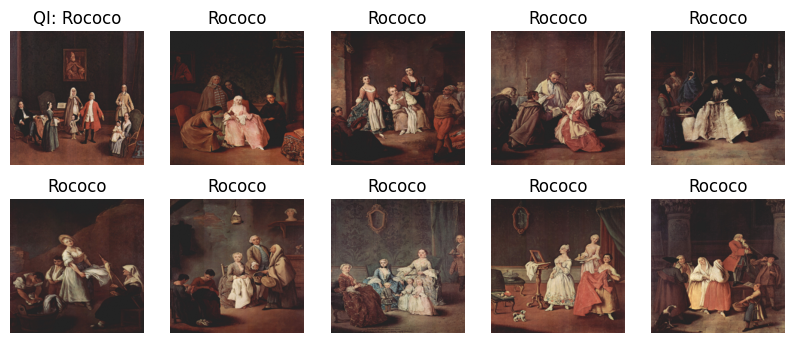

In [25]:
def show_result(similar_images, query_image):
    k = len(similar_images)

    # Crear una figura y subgráficas (subplots)
    fig, axes = plt.subplots(2, int((k + 1)/2), figsize=(10, 4))

    axes = axes.flatten()

    # Plotear la imagen de consulta
    axes[0].imshow(query_image)
    axes[0].set_title("QI: " + os.listdir(test_dir)[query_index].split('-')[1].split('.')[0])
    axes[0].axis('off')

    # Plotear las imágenes más similares
    for i, sim_img in enumerate(similar_images):
        axes[i + 1].imshow(sim_img)
        img_name = Path(df['image'][indices[0][i]]).name.split('-')[1].split('.')[0]  
        axes[i + 1].set_title(img_name)
        axes[i + 1].axis('off')

    plt.show()

show_result(nearest_images, query_image)